<a href="https://colab.research.google.com/github/jt42calvin/Little-Red-Riding-Hood/blob/main/Little_Red_Ridinghood_DATA_202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Midterm Project Report: When Did Little Red Ridinghood Get Eaten?



By: Jacob Tocila, Payton Frens, and Ella Addink

## Introduction

We found an interesting graphic on Kaggle aiming to determine when Little Red Riding Hood (from the fairy tale) was most likely eaten. The author claims with the graphic that Little Red Riding Hood was probably eaten in June. The author used a Wikipedia dataset of 462 wolf attacks worldwide, the earliest in the 14th century, and totaled the attacks by month and by gender. The dataset includes the columns:

*   Victims: the name, age, and gender of the victim(s) (not all present in every record)
*   Date: date or year of the attack (variety of entry forms as well)
*   Type of attack: whether the attack was predatory, unprovoked, rabid, etc.
*   Location: place of attack
*   Notes: description of the attack if any

The data can be found here:

https://www.kaggle.com/datasets/danela/global-wolf-attacks

And the graphic can be found here and is included below:

https://www.kaggle.com/code/uwegradwohl/was-little-red-ridinghood-eaten-up-in-june

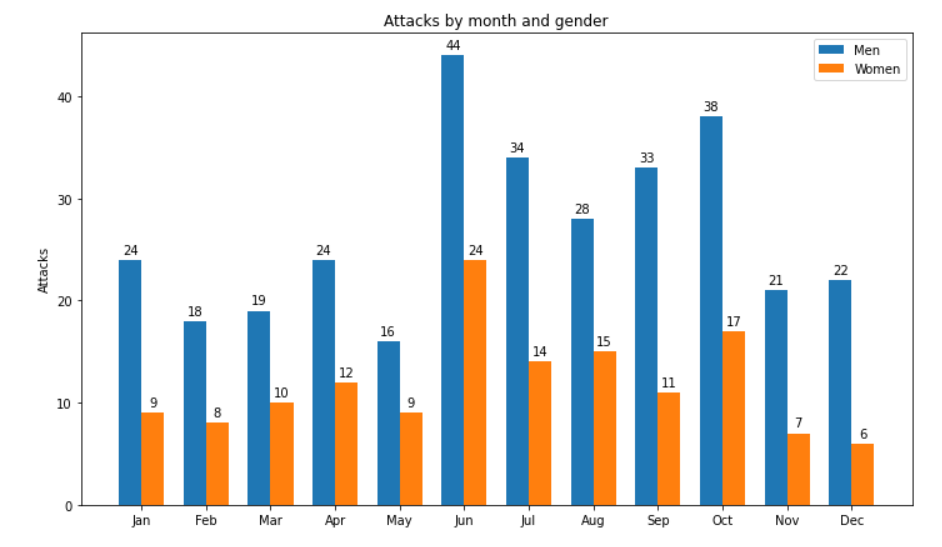

We decided to replicate this graphic, but with a more complete count of the victims each month. In the data wrangling section, we parse the victims, notes, and date columns for each attack to determine the month, the number of victims in each attack (not just one per record), and their genders.

This approach is a much more "Christian-like" way of looking at this dataset because we are looking for the specific people in the dataset and the accurate count. By separating into male, female, and unknown gender, we are not assuming the gender of anyone or missing cases where there are multiple victims in a single incident.
  * We are, however, excluding records from our month analysis which do not have a month present in the Date column.

## Loading the Data

In [ ]:
import kagglehub
import os
import re
import glob
import pandas as pd
import plotly.express as px

# Dataset sources:
# https://www.kaggle.com/datasets/danela/global-wolf-attacks?resource=download
# https://en.wikipedia.org/wiki/List_of_wolf_attacks

# Load dataset from Kaggle or fallback to local CSV (This try/except block handles both cases, running locally or on Google Colab)
try:
    dataset_path = kagglehub.dataset_download("danela/global-wolf-attacks")
    print("Path to dataset files:", dataset_path)

    if os.path.isdir(dataset_path):
        csv_files = glob.glob(os.path.join(dataset_path, "*.csv")) # Handle directory with CSV files
        if csv_files:
            wolf_attacks = pd.read_csv(csv_files[0])
        else:
            raise FileNotFoundError("No CSV files found in downloaded dataset")
    else:
        wolf_attacks = pd.read_csv(dataset_path) # Handle direct CSV file path

except Exception as e:
    print(f"Could not load from Kaggle ({e}), using local file")
    wolf_attacks = pd.read_csv("global_wolves.csv") # Fallback to local CSV file


100%|██████████| 24.2k/24.2k [00:00<00:00, 13.8MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/danela/global-wolf-attacks/versions/4


## Data Wrangling

### Counting Victims by Gender

The function below will count all the victims of wolf attacks in the dataset. We split the number of victims into three categories: male, female, and unknown (this will be helpful later). We also made sure to include any synonyms of male/female (men/boys, women/girls, etc) into our count. For example, if the victim table contained "his wife" or "her husband", we added one person in the "male" and "female" category. If there was no gender specified (ex: children, adults, etc.), we counted it in the "Unknown" category.

In [ ]:
# Constants
MONTH_ORDER = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

def count_victims(text):
    text_lower = text.lower()
    word_to_num = {
      'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5,
      'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10,
      'eleven': 11, 'twelve': 12, 'thirteen': 13, 'fourteen': 14, 'fifteen': 15
    } # No difference in 0-15 (word) and 0-100 (word)
    male_count = 0
    female_count = 0
    unknown_count = 0

    # Males
    for synonym in ['male', 'man', 'men', 'boy', 'boys']:
        digit_match = re.search(rf'(\d+)\s+{synonym}s\b', text_lower)
        if digit_match:
            male_count += int(digit_match.group(1))
            break
        if re.search(rf'\b(a|an|adult)\s+{synonym}\b', text_lower): male_count += 1
        for word, num in word_to_num.items():
            if re.search(rf'\b{word}\s+{synonym}s?', text_lower): male_count += num; break

    # Females
    for synonym in ['female', 'woman', 'women', 'girl', 'girls']:
        digit_match = re.search(rf'(\d+)\s+{synonym}s\b', text_lower)
        if digit_match:
            female_count += int(digit_match.group(1))
            break
        if re.search(rf'(?:^|[,\s])(a|an)\s+{synonym}\b', text_lower): female_count += 1
        if re.search(rf'\band\s+a\s+{synonym}\b', text_lower): female_count += 1
        if re.search(rf'\badult\s+{synonym}\b', text_lower): female_count += 1
        for word, num in word_to_num.items():
            if re.search(rf'\b{word}\s+{synonym}s?', text_lower): female_count += num; break

    # Edge cases
    comma_males = len(re.findall(r',\s*\d*\s*male(?!s)', text_lower))
    comma_females = len(re.findall(r',\s*\d*\s*female(?!s)', text_lower))
    space_males = len(re.findall(r'male[A-Z]', text))
    space_females = len(re.findall(r'female[A-Z]', text))

    if male_count == 0:
        male_count = max(comma_males, space_males)
    if female_count == 0:
        female_count = max(comma_females, space_females)

    if male_count == 0 and re.search(r'and\s+\w+[^,]*,?\s*(?:adult\s+)?males\b', text_lower): male_count = 2
    if female_count == 0 and re.search(r'and\s+\w+[^,]*,?\s*(?:adult\s+)?females\b', text_lower): female_count = 2

    if 'his wife' in text_lower: male_count = max(male_count, 1); female_count = max(female_count, 1)
    if 'her husband' in text_lower: male_count = max(male_count, 1); female_count = max(female_count, 1)

    # Count unknown victims if no gender info found
    if male_count == 0 and female_count == 0:
        others_match = re.search(r'and\s+(\w+)\s+others?', text_lower)
        if others_match:
            word = others_match.group(1)
            if word.isdigit():
                unknown_count = int(word) + 1
            elif word in word_to_num:
                unknown_count = word_to_num[word] + 1
        elif re.search(r'\b(one|a|an)\s+(resident|person|individual)\b', text_lower):
            unknown_count = 1
        else:
            adults_match = re.search(r'(\w+)\s+adults?\s+and\s+(\w+)\s+children', text_lower)
            if adults_match:
                word1, word2 = adults_match.groups()
                count1 = int(word1) if word1.isdigit() else word_to_num.get(word1, 0)
                count2 = int(word2) if word2.isdigit() else word_to_num.get(word2, 0)
                unknown_count = count1 + count2
            else:
                for keyword in ['people', 'residents', 'victims', 'persons', 'individuals', 'children']:
                    digit_match = re.search(rf'(\d+)\s+{keyword}', text_lower)
                    if digit_match: unknown_count = int(digit_match.group(1)); break
                    for word, num in word_to_num.items():
                        if re.search(rf'\b{word}\s+{keyword}', text_lower): unknown_count = num; break
                    if unknown_count > 0: break

    return pd.Series({'Male_Count': male_count, 'Female_Count': female_count, 'Unknown_Count': unknown_count})

### Extract month of each attack

Below is our code for getting the months when wolf attacks occurred. We excluded any cases where wolf attacks occurred over the span of several months (ex: March - September 2024) and if one row included two months (ex: January 6, 1728 and December 17, 1727) since neither specified the number of attacks in a particular month.

In [ ]:
def get_month(text):
    # Return month from "Date" column
    if 'â€"' in text or '-' in text or 'and' in text: return None
    month = re.search(
        r'\b(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)\b',
        text, re.IGNORECASE)
    return month.group(0).capitalize() if month else None

### Apply functions to data

The raw data before we apply our functions can be seen below.

In [ ]:
print(wolf_attacks.head(10))

                                            Victims                 Date  \
0                            Martino Raineri, male     January 17, 2022    
1                           Stanley Russ, 72, male         May 29, 2020    
2                  Vlastimil Vejrosta and his wife       April 30, 2020    
3                       Timur Makhametov, 23, male    December 30, 2019    
4                             Unknown, adult, male    December 12, 2019    
5                       Vladislav Lomako, 56, male     December 8, 2019    
6               Zinaida Kozlovskaya, adult, female    November 22, 2019    
7  Petr Grishchenko and Sergei Budnik, adult males     October 24, 2019    
8            Four adults, three males and a female      October 7, 2019    
9    Three adult residents, two males and a female   September 14, 2019    

  Type of attack                                           Location  \
0     Unprovoked  Between Malga Seconda Posta and Forte Cherle, ...   
1     Unprovoked     

With our two functions, count_victims and get_month, we created columns for the total number of male victims, female victims, victims with an unspecified gender, and the month the attack occured.

In [ ]:
# Apply data wrangling functions to create Month and gender count columns
wolf_attacks[['Male_Count', 'Female_Count', 'Unknown_Count']] = wolf_attacks['Victims'].apply(count_victims)
wolf_attacks['Month'] = wolf_attacks['Date'].apply(get_month)

Afterwards, our data with four new columns looks like this:

In [ ]:
print(wolf_attacks.head(10))

                                            Victims                 Date  \
0                            Martino Raineri, male     January 17, 2022    
1                           Stanley Russ, 72, male         May 29, 2020    
2                  Vlastimil Vejrosta and his wife       April 30, 2020    
3                       Timur Makhametov, 23, male    December 30, 2019    
4                             Unknown, adult, male    December 12, 2019    
5                       Vladislav Lomako, 56, male     December 8, 2019    
6               Zinaida Kozlovskaya, adult, female    November 22, 2019    
7  Petr Grishchenko and Sergei Budnik, adult males     October 24, 2019    
8            Four adults, three males and a female      October 7, 2019    
9    Three adult residents, two males and a female   September 14, 2019    

  Type of attack                                           Location  \
0     Unprovoked  Between Malga Seconda Posta and Forte Cherle, ...   
1     Unprovoked     

## Plot Replication

Now we split the wolf attacks by gender variations like in the original graph. To do so, we must first pivot the dataset longer so there are columns for month, gender, and victim count.

Plot the total male and female victims by month in a side-by-side bar graph.

In [ ]:
def plot_males_and_females_by_month(wolf_attacks):
    """Plot male and female victim sums by month with bars grouped side by side."""
    # Sum counts by month
    monthly_sums = wolf_attacks.groupby('Month')[['Male_Count', 'Female_Count']].sum()

    # Reset index and prepare data
    df = monthly_sums.reset_index()
    df['Month'] = pd.Categorical(df['Month'], categories=MONTH_ORDER, ordered=True)
    df = df.dropna(subset=['Month'])

    # Melt to long form
    df_long = df.melt(id_vars='Month', value_vars=['Male_Count', 'Female_Count'],
                      var_name='Gender', value_name='Attack_Count')
    df_long['Gender'] = df_long['Gender'].str.replace('_Count', '')

    fig = px.bar(df_long,
                x='Month',
                y='Attack_Count',
                color='Gender',
                title='Wolf Attack Victims by Month (Male / Female)',
                category_orders={'Month': MONTH_ORDER},
                color_discrete_map={'Male': '#1e78b4', 'Female': '#ff7f0f'},
                barmode='group')

    fig.update_traces(texttemplate='%{y}', textposition='outside', textfont_color='black')
    fig.update_layout(xaxis_title='Month', yaxis_title='Number of Victims')
    fig.show()

plot_males_and_females_by_month(wolf_attacks) # this makes the bar graph

## Alternatives

### 1. Separate Line Graphs of Wolf Attack Victims by Month

Another way of showing this data is to make separate plots of the attacks for each gender category and the overall total. We decided this would be best shown using line charts.

Plot all wolf attacks by month in a line graph.

In [ ]:
def plot_attacks_by_month(wolf_attacks):
    """Plot total number of victims (all genders) by month."""
    # Sum all victim counts by month
    monthly_totals = wolf_attacks.groupby('Month')[['Male_Count', 'Female_Count', 'Unknown_Count']].sum()
    monthly_totals['Total_Count'] = monthly_totals.sum(axis=1)

    # Reset index and ensure month ordering
    df = monthly_totals.reset_index()
    df['Month'] = pd.Categorical(df['Month'], categories=MONTH_ORDER, ordered=True)
    df = df.dropna(subset=['Month']).sort_values('Month')

    fig = px.line(df, x='Month', y='Total_Count', title='Number of All Wolf Attack Victims by Month')
    fig.update_layout(xaxis_title='Month', yaxis_title='Number of Victims')
    fig.show()

plot_attacks_by_month(wolf_attacks) # Sum of all attacks by month - line

Plot the total female victims by month in a line graph.

In [ ]:
def plot_female_attacks_by_month(wolf_attacks):
    """Plot sum of female victims by month."""
    monthly_sums = wolf_attacks.groupby('Month')['Female_Count'].sum().reindex(MONTH_ORDER).fillna(0).reset_index()
    monthly_sums.columns = ['Month', 'Attack_Count']
    monthly_sums['Month'] = pd.Categorical(monthly_sums['Month'], categories=MONTH_ORDER, ordered=True)
    monthly_sums = monthly_sums.dropna(subset=['Month'])

    fig = px.line(monthly_sums, x='Month', y='Attack_Count', title='Number of Female Wolf Attack Victims by Month')
    fig.update_layout(xaxis_title='Month', yaxis_title='Number of Victims', yaxis_range=[0,40])
    fig.show()

plot_female_attacks_by_month(wolf_attacks) # makes the line graph

Plot the total male victims by month in a line graph.

In [ ]:
def plot_male_attacks_by_month(wolf_attacks):
    """Plot sum of male victims by month."""
    monthly_sums = wolf_attacks.groupby('Month')['Male_Count'].sum().reindex(MONTH_ORDER).fillna(0).reset_index()
    monthly_sums.columns = ['Month', 'Attack_Count']
    monthly_sums['Month'] = pd.Categorical(monthly_sums['Month'], categories=MONTH_ORDER, ordered=True)
    monthly_sums = monthly_sums.dropna(subset=['Month'])

    fig = px.line(monthly_sums, x='Month', y='Attack_Count', title='Number of Male Wolf Attack Victims by Month')
    fig.update_layout(xaxis_title='Month', yaxis_title='Number of Victims', yaxis_range=[0,40])
    fig.show()

plot_male_attacks_by_month(wolf_attacks) # line

Plot the total victims of unknown gender by month in a line graph.

In [ ]:
def plot_unknown_attacks_by_month(wolf_attacks):
    """Plot sum of unknown gender victims by month."""
    monthly_sums = wolf_attacks.groupby('Month')['Unknown_Count'].sum().reindex(MONTH_ORDER).fillna(0).reset_index()
    monthly_sums.columns = ['Month', 'Attack_Count']
    monthly_sums['Month'] = pd.Categorical(monthly_sums['Month'], categories=MONTH_ORDER, ordered=True)
    monthly_sums = monthly_sums.dropna(subset=['Month'])

    fig = px.line(monthly_sums, x='Month', y='Attack_Count', title='Number of Wolf Attack Victims with Unknown Gender by Month')
    fig.update_layout(xaxis_title='Month', yaxis_title='Number of Victims', yaxis_range=[0,140])
    fig.show()

plot_unknown_attacks_by_month(wolf_attacks) # line

### 2. Wolf Attack Victims by Month Including Male, Female, and Unknown in a Bar Chart

As an additional improvement of the original graph, we made a 3-way bar chart, including the count of victims with an unknown gender.

Plot total male, total female, and total unknown victims by month

In [ ]:
def plot_all_genders_by_month(wolf_attacks):
    """Plot male, female, and unknown victim sums by month (3-way bar chart)."""
    # Sum counts by month
    monthly_sums = wolf_attacks.groupby('Month')[['Male_Count', 'Female_Count', 'Unknown_Count']].sum()

    # Reset index and prepare data
    df = monthly_sums.reset_index()
    df['Month'] = pd.Categorical(df['Month'], categories=MONTH_ORDER, ordered=True)
    df = df.dropna(subset=['Month'])

    # Melt to long form
    df_long = df.melt(id_vars='Month', value_vars=['Male_Count', 'Female_Count', 'Unknown_Count'],
                      var_name='Gender', value_name='Attack_Count')
    df_long['Gender'] = df_long['Gender'].str.replace('_Count', '')

    fig = px.bar(
        df_long,
        x='Month',
        y='Attack_Count',
        color='Gender',
        title='Monthly Wolf Attack Victims by Gender (Male / Female / Unknown)',
        category_orders={'Month': MONTH_ORDER},
        color_discrete_map={'Male': '#1e78b4', 'Female': '#ff7f0f', 'Unknown': '#33a02c'},
        barmode='group'
    )

    fig.update_traces(texttemplate='%{y}', textposition='outside', textfont_color='black')
    fig.update_layout(xaxis_title='Month', yaxis_title='Number of Victims')
    fig.show()

plot_all_genders_by_month(wolf_attacks) # bar

Finally, we wanted to show the individual wolf attack incidents in our bar chart by month and gender.

What's causing such high peaks in March, April, and June for unknown gendered victims? With the below graphic, we can look into this on a case-by-case basis.

Tip: Drag an area of the graph to zoom in! Double click to exit zoom

In [ ]:
def plot_all_genders_by_month_breakdown_by_incident(wolf_attacks):
    """Plot a bar chart showing individual wolf attack incidents by month and gender.

    Args:
        wolf_attacks: DataFrame with columns ['Month', 'Male_Count', 'Female_Count', 'Unknown_Count', 'Notes']
    """
    # Prepare data for plotting - each row becomes a bar
    df = wolf_attacks.copy()
    df['Month'] = pd.Categorical(df['Month'], categories=MONTH_ORDER, ordered=True)
    df = df.dropna(subset=['Month'])
    df = df.reset_index()  # Add row numbers as index
    df['Row'] = df.index

    # Melt to long form - create separate rows for Male, Female, Unknown
    rows_list = []
    for idx, row in df.iterrows():
        if row['Male_Count'] > 0:
            rows_list.append({'Month': row['Month'], 'Gender': 'Male', 'Count': row['Male_Count'],
                            'Row': row['Row'], 'Notes': str(row.get('Notes', 'N/A'))})
        if row['Female_Count'] > 0:
            rows_list.append({'Month': row['Month'], 'Gender': 'Female', 'Count': row['Female_Count'],
                            'Row': row['Row'], 'Notes': str(row.get('Notes', 'N/A'))})
        if row['Unknown_Count'] > 0:
            rows_list.append({'Month': row['Month'], 'Gender': 'Unknown', 'Count': row['Unknown_Count'],
                            'Row': row['Row'], 'Notes': str(row.get('Notes', 'N/A'))})

    df_long = pd.DataFrame(rows_list)

    # Calculate monthly sums for text labels
    monthly_sums = df_long.groupby(['Month', 'Gender'])['Count'].sum().reset_index()
    monthly_sums.columns = ['Month', 'Gender', 'Total']

    fig = px.bar(
        df_long,
        x='Month',
        y='Count',
        color='Gender',
        title='Monthly Wolf Attack Victims by Gender (Male / Female / Unknown) [Breakdown by Incident]',
        category_orders={'Month': MONTH_ORDER},
        color_discrete_map={'Male': '#1e78b4', 'Female': '#ff7f0f', 'Unknown': '#33a02c'},
        barmode='group',
        hover_data={'Row': True, 'Notes': True, 'Count': True}
    )

    # Map gender to x-offset for grouped bars
    gender_offset = {'Male': -0.27, 'Female': 0, 'Unknown': 0.27}

    # Add total sum text above each group
    for _, total_row in monthly_sums.iterrows():
        month = total_row['Month']
        gender = total_row['Gender']
        total = total_row['Total']

        # Get the month index for x position
        month_idx = MONTH_ORDER.index(month)
        x_pos = month_idx + gender_offset.get(gender, 0)

        fig.add_annotation(
            x=x_pos,
            y=total,
            text=str(int(total)),
            showarrow=False,
            yshift=10,
            font=dict(color='black', size=12),
            xref='x',
            yref='y'
            )

    fig.update_layout(xaxis_title='Month', yaxis_title='Number of Victims', barmode='group')
    fig.show()

plot_all_genders_by_month_breakdown_by_incident(wolf_attacks) # Individual incidents by month and gender, best visualization - bar

## Summary

One key takeaway from this project was that wrangling the data can get very complicated very quickly when the data is messy. We spent more time trying to make sure we were identifying as many attacks and genders of the victims as possible using regular expressions than making the graphics. To improve our ability to determine when Red Riding Hood was eaten, a larger, more complete dataset would be ideal. If we had more time, we could also try narrowing down the wolf attacks to only Europe which is where the tale of Little Red Riding Hood likely originated.

In summary, our graphics reveal that:
*   If we assume that Little Red Riding Hood was a girl, she was mostly likely eaten in June.
* If we do not assume Little Red Riding Hood's gender, then they were still most likely eaten in June.

Thank you for coming to our TED talk.

